In [8]:
%%capture
%cd scripts

# Originally written by TG, revised by NCK

In [9]:
from scipy.stats import ttest_ind
import numpy as np
from itertools import product
import os

#import graph_tool.all as gt
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import hypergeom, pearsonr
import seaborn as sns
from sklearn.cluster import KMeans

#from functions import *
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind, zscore
from statannotations.Annotator import Annotator
import warnings
from adjustText import adjust_text

# Suppress all warnings
warnings.filterwarnings("ignore")

# Style
sns.set_theme(context='talk', style='white', palette='Set2')
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.size': 22,
    'axes.titlesize': 'medium',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'legend.title_fontsize': 'medium',
    'figure.titlesize': 'x-large',
})


# Figure transparency
# matplotlib.rcParams['figure.facecolor'] = (1., 0., 0., 0.3)  # Debugging
matplotlib.rcParams['figure.facecolor'] = (1., 0., 0., 0.)

# Set palette
# palette = sns.color_palette([
#     "#6acc54",
#     "#617a43",
#     "#cfde49",
#     "#c2d59d",
#     "#9ca242"])
# sns.set_palette(palette)

In [10]:
edge_att = pd.read_csv('../../data/freeze3/c15_att_02_11/MSSM_attn_all_224.csv')

edge_att_GRN = edge_att[edge_att['edge_type'] == 'TF_TG']
edge_att_GRN['att_ave'] = edge_att_GRN.iloc[:,5:13].mean(axis=1)
edge_att_GRN['edge_id'] = edge_att_GRN['ct_GRN'] + '_' + edge_att_GRN['id']

## Load Meta
meta = pd.read_csv('../../data/metadata_dec.csv')

edge_att_GRN_plot = edge_att_GRN.iloc[:,13:16]

tmp_var = meta[['SubID', 'CERAD', 'BRAAK_AD', 'CDRScore']]
edge_att_GRN_plot = edge_att_GRN_plot.merge(tmp_var, how="left", left_on="sample", right_on="SubID")

edge_att_GRN_plot_dropna = edge_att_GRN_plot.dropna()

## BRAAK 0,1,2 early, 3,4 mid, 5,6 late 

## cogdx 0 ctl,  0.5 1  MCI,  2>= demina/AD


In [11]:
def categorize_braak(value):
    if value in [0, 1, 2]:
        return 'early'
    elif value in [3, 4]:
        return 'mid'
    elif value in [5, 6]:
        return 'late'
    
def categorize_cogdx(value):
    if value in [0]:
        return 'CTL'
    elif value in [0.5, 1]:
        return 'MCI'
    elif value in [2,3,4,5]:
        return 'AD'
    
edge_att_GRN_plot_dropna['BRAAK_Stage'] = edge_att_GRN_plot_dropna['BRAAK_AD'].apply(categorize_braak)
edge_att_GRN_plot_dropna['CDRScore_Stage'] = edge_att_GRN_plot_dropna['CDRScore'].apply(categorize_cogdx)
edge_att_GRN_plot_dropna['CERAD'] = edge_att_GRN_plot_dropna['CERAD'].astype(str)

edge_att_GRN_plot_dropna['edge_id'] = edge_att_GRN_plot_dropna['edge_id'].str.replace('GRN_', '', regex=False)
edge_att_GRN_plot_dropna.head()

,sample,att_ave,edge_id,SubID,CERAD,BRAAK_AD,CDRScore,BRAAK_Stage,CDRScore_Stage
5724,M153,0.196838,Astro_ATOH8_SLC16A9,M153,2.0,3.0,1.0,mid,MCI
5725,M153,0.156535,Astro_ATOH8_MASP1,M153,2.0,3.0,1.0,mid,MCI
5726,M153,0.196841,Astro_BCL6_CD44,M153,2.0,3.0,1.0,mid,MCI
5727,M153,0.049366,Astro_BCL6_CP,M153,2.0,3.0,1.0,mid,MCI
5728,M153,0.196841,Astro_BCL6_ANGPT1,M153,2.0,3.0,1.0,mid,MCI


In [12]:
# Get top micro by count
df = edge_att_GRN_plot_dropna.copy()
df['count'] = 1
df = df[['edge_id', 'count']].groupby('edge_id').sum()
df = df.sort_values(by='count', ascending=False)
df = df.loc[[s.startswith('Micro_') for s in df.index]]
df.head()

,count
edge_id,
Micro_NFATC2_IKZF1,333
Micro_NFATC2_DOCK8,313
Micro_IRF8_APBB1IP,291
Micro_IRF8_DOCK8,282
Micro_NFATC2_PTPRC,281


In [13]:
# NCK
# Manual selection
select_edge = ['Astro_TCF7L1_BOC', 'Oligo_TCF12_FRMD4B', 'Micro_NFATC2_IKZF1']  # 'Oligo_TCF12_CREB5'

edge_att_GRN_plot_dropna_try = edge_att_GRN_plot_dropna.loc[edge_att_GRN_plot_dropna['edge_id'].isin(select_edge)]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Oligo_TCF12_FRMD4B_mid vs. Oligo_TCF12_FRMD4B_late: Mann-Whitney-Wilcoxon test two-sided, P_val:5.841e-04 U_stat=2.199e+03
Astro_TCF7L1_BOC_early vs. Astro_TCF7L1_BOC_mid: Mann-Whitney-Wilcoxon test two-sided, P_val:3.510e-04 U_stat=1.190e+02
Micro_NFATC2_IKZF1_early vs. Micro_NFATC2_IKZF1_mid: Mann-Whitney-Wilcoxon test two-sided, P_val:4.588e-02 U_stat=3.655e+03
Oligo_TCF12_FRMD4B_early vs. Oligo_TCF12_FRMD4B_late: Mann-Whitney-Wilcoxon test two-sided, P_val:9.966e-06 U_stat=2.649e+03
Micro_NFATC2_IKZF1_early vs. Micro_NFATC2_IKZF1_late: Mann-Whitney-Wilcoxon test two-sided, P_val:1.784e-06 U_stat=5.847e+03
Astro_TCF7L1_BOC_early vs. Astro_TCF7L1_BOC_late: Mann-Whitney-Wilcoxon test two-sided, P_val:1.456e-05 U_stat=3.930e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *

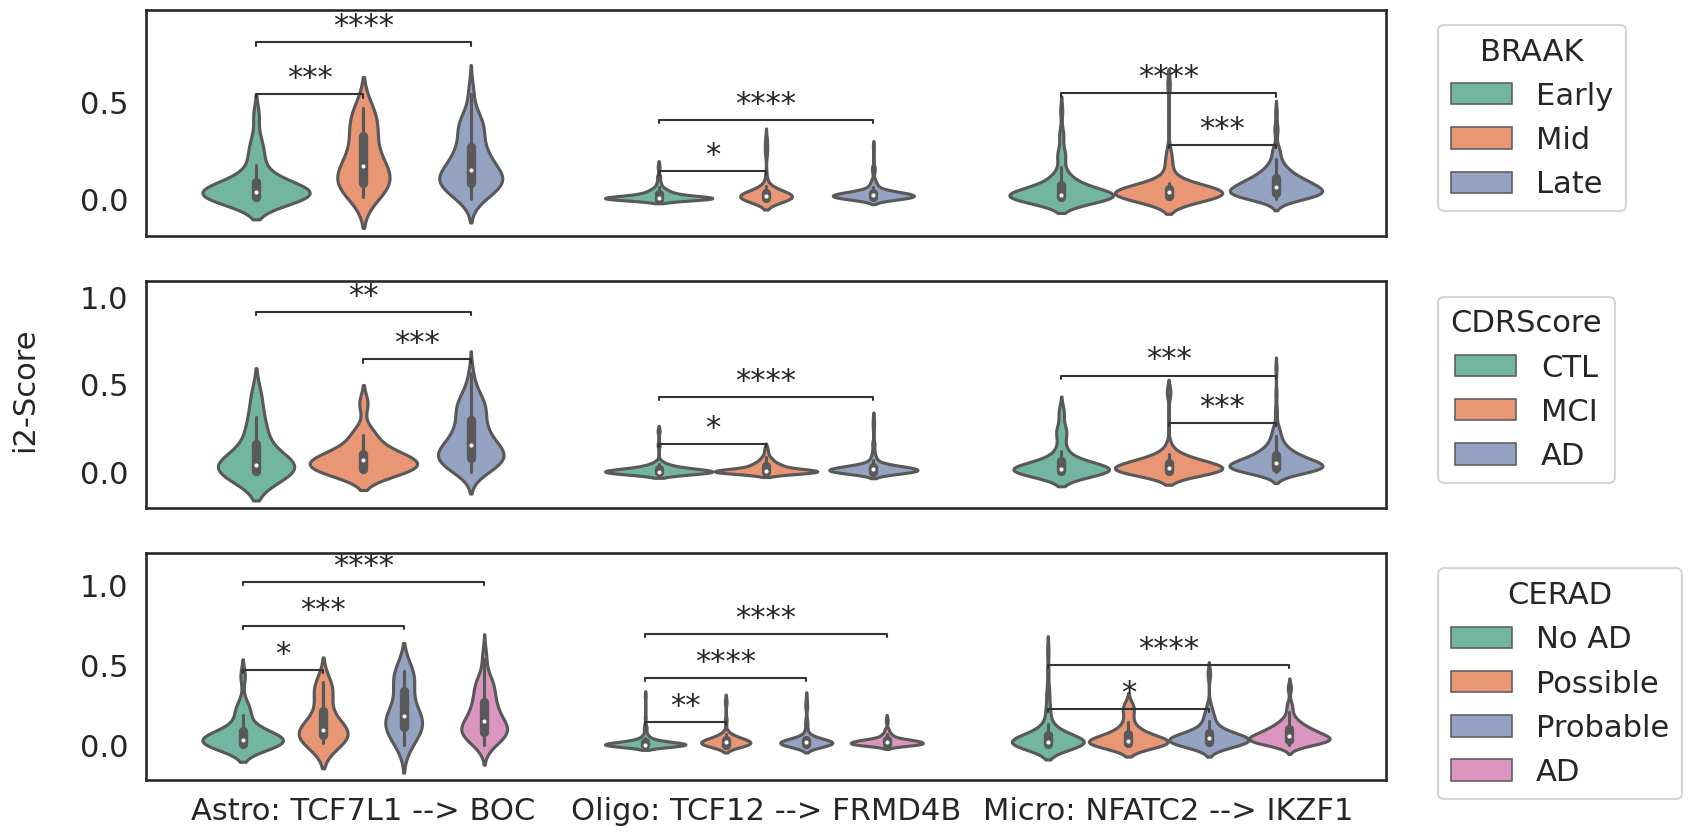

In [14]:
# NCK
from itertools import product

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(16, 10))

order =  np.unique(edge_att_GRN_plot_dropna_try['edge_id']).tolist()

# NCK
state_pairs = [("early", "mid"), ("mid", "late"), ("early", "late")]
pairs = [[(e, sg) for sg in g] for e, g in product(select_edge, state_pairs)]
hue_order = ['early', 'mid', 'late']

sns.violinplot(data=edge_att_GRN_plot_dropna_try, x="edge_id", y="att_ave", order=order, hue="BRAAK_Stage", hue_order=hue_order, ax=axs[0])
#axs[0].set_ylabel('Attention Score', fontsize = 6)
axs[0].set_ylabel('')
axs[0].set_xlabel('')
axs[0].legend(title='BRAAK',loc='upper left', bbox_to_anchor=(1.03, 1))

# NCK
for t in axs[0].legend_.get_texts():
    t.set_text(t.get_text().capitalize())

annotator0 = Annotator(axs[0], pairs, data=edge_att_GRN_plot_dropna_try, x="edge_id", y="att_ave", order=order, hue="BRAAK_Stage", hue_order=hue_order)
annotator0.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True)  # NCK
#annotator.apply_and_annotate()
annotator0.apply_test()
annotator0.annotate()

####################

order =  np.unique(edge_att_GRN_plot_dropna_try['edge_id']).tolist()

# NCK
state_pairs = [("CTL", "MCI"), ("CTL", "AD"), ("MCI", "AD")]
pairs = [[(e, sg) for sg in g] for e, g in product(select_edge, state_pairs)]
hue_order = ['CTL', 'MCI', 'AD']

sns.violinplot(data=edge_att_GRN_plot_dropna_try, x="edge_id", y="att_ave", order=order, hue="CDRScore_Stage", hue_order=hue_order, ax=axs[1])
#axs[1].set_ylabel('Attention Score', fontsize = 6)
axs[1].set_ylabel('')
axs[1].set_xlabel('')
axs[1].legend(title='CDRScore',loc='upper left', bbox_to_anchor=(1.03, 1))
#axs[1].xticks(rotation=30, fontsize = 6)

annotator1 = Annotator(axs[1], pairs, data=edge_att_GRN_plot_dropna_try, x="edge_id", y="att_ave", order=order, hue="CDRScore_Stage", hue_order=hue_order)
annotator1.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True)  # NCK
#annotator.apply_and_annotate()
annotator1.apply_test()
annotator1.annotate()

####################

order =  np.unique(edge_att_GRN_plot_dropna_try['edge_id']).tolist()

# NCK
state_pairs = [("1.0", "2.0"), ("1.0", "3.0"), ("1.0", "4.0")]
pairs = [[(e, sg) for sg in g] for e, g in product(select_edge, state_pairs)]
hue_order = ['1.0', '2.0', '3.0', '4.0']
conv_dict = {'1.0': 'No AD', '2.0': 'Possible', '3.0': 'Probable', '4.0': 'AD'}

sns.violinplot(data=edge_att_GRN_plot_dropna_try, x="edge_id", y="att_ave", order=order, hue="CERAD", hue_order=hue_order, ax=axs[2])
#axs[2].set_ylabel('Attention Score', fontsize = 6)
axs[2].set_ylabel('')
axs[2].set_xlabel('')
axs[2].legend(title='CERAD', loc='upper left', bbox_to_anchor=(1.03, 1))

# NCK
for t in axs[2].legend_.get_texts():
    t.set_text(conv_dict[t.get_text()])

axs[2].set_xticklabels(select_edge)  # Without rotation
# axs[2].set_xticklabels(select_edge, rotation=-10)  # With rotation

annotator2 = Annotator(axs[2], pairs, data=edge_att_GRN_plot_dropna_try, x="edge_id", y="att_ave", order=order, hue="CERAD", hue_order=hue_order)
annotator2.configure(test='Mann-Whitney', text_format='star', loc='inside', hide_non_significant=True)  # NCK
#annotator.apply_and_annotate()
annotator2.apply_test()
annotator2.annotate()

# Format edge symbols on X axis
labels = axs[2].get_xticklabels()
for l in labels:
    text = l.get_text()
    text = text.split('_')
    text = '_'.join(text[:-2]) + ': ' + ' --> '.join(text[-2:])
    l.set_text(text)
axs[2].set_xticklabels(labels)

#plt.tight_layout()

# Show the plot

#plt.xticks(rotation=30, fontsize = 12)
#plt.ylabel('Attention Score')
#plt.xlabel('')
#plt.legend(title='AD Progression (CERAD)',loc='upper left', bbox_to_anchor=(1.03, 1))
fig.text( 0.04, 0.5,'i2-Score', va='center', rotation='vertical')  # , fontsize=12
plt.savefig('../plots/figure_4_distribution.pdf', bbox_inches='tight')
plt.show()